In [9]:
import xarray as xr
import pandas as pd
import altair as alt
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit


In [10]:
sos_ds = xr.open_dataset("example_dataset.nc")
sos_ds = sos_ds.drop_duplicates('time')

# Define functions for calculations of Wind Gradient

These calculations are done by fitting log-linear curve to 3 points, the 3 measurements including and surrounding the measurement height of interest. This means we can only calculate wind gradient at 3, 5, 10, and 15 meters (on the central tower).

In [11]:
Z0 = 0.005 #Lapo, Nijssen, and Lundquist, 2019

def log_linear_fn(z, a, b):
    return a*np.log(z/Z0) + b * (z/Z0)
def fit_log_linear(values, heights):
    if all([np.isfinite(v) for v in values]):
        [a,b], _ = scipy.optimize.curve_fit(log_linear_fn, heights, values)
        return a,b
    else:
        return np.nan, np.nan
def calculate_log_linear_gradient(a_u, b_u, a_v, b_v, height):
    return np.sqrt(((a_u/height) + (b_u/Z0))**2 + ((a_v/height) + (b_v/Z0))**2)

def calculate_wind_gradient_for_height(ds, calculation_height):
    """ ToDo: - implement for different towers besides C
              - make it work if we use datasets that have 1m instead of 2m measurements
    """
    # identify two heights on either side of this height 
    calculation_height_to_fit_heights = {
        3: [2, 3, 5],
        5: [3, 5, 10],
        10: [5, 10, 15],
        15: [10, 15, 20],
    }
    
    heights = calculation_height_to_fit_heights[calculation_height]
    u_variables = [f'u_{h}m_c' for h in heights]
    v_variables = [f'v_{h}m_c' for h in heights]

    # create_datasets for u and v data 
    u_ds = ds[u_variables].to_dataframe().rename(columns=dict(zip(u_variables, heights)))
    v_ds = ds[v_variables].to_dataframe().rename(columns=dict(zip(v_variables, heights)))
    # calculate fitted loglinear parameters
    u_ds['params'] = u_ds.apply(lambda row: fit_log_linear(
        [row[h] for h in heights],
        heights
    ), axis = 1)
    v_ds['params'] = v_ds.apply(lambda row: fit_log_linear(
        [row[h] for h in heights],
        heights
    ), axis = 1)
    u_ds['a_u'] = u_ds['params'].apply(lambda tup: tup[0])
    u_ds['b_u'] = u_ds['params'].apply(lambda tup: tup[1])
    v_ds['a_v'] = v_ds['params'].apply(lambda tup: tup[0])
    v_ds['b_v'] = v_ds['params'].apply(lambda tup: tup[1])
    # merged_parameters = u_ds[['a_u', 'b_u']].merge(v_ds[['a_v', 'b_v']], on='time')
    merged_parameters = u_ds[['a_u', 'b_u']].join(v_ds[['a_v', 'b_v']]).reset_index().drop_duplicates()
    gradient = merged_parameters.apply(
        lambda row: calculate_log_linear_gradient(row['a_u'], row['b_u'], row['a_v'], row['b_v'], calculation_height),
        axis=1
    )
    return gradient

# Define functions for calculations of Temperature Gradient

These calculations are done with a simple central differencing method using 3 measurements, those including and surrounding the measurement height of interest. This means we can calculate temperature gradient at 1-meter intervals between 2 and 19 meters (on the central tower).

In [15]:
def calculate_temperature_gradient_for_height(ds, calculation_height):
    assert (calculation_height > 1)
    assert (calculation_height < 20)
    [height_below, height_above] = [calculation_height - 1, calculation_height + 1]
    temp_diff = sos_ds[f'Tpotvirtual_{height_above}m_c'] - sos_ds[f'Tpotvirtual_{height_below}m_c']
    height_diff = height_above - height_below
    gradient = temp_diff / height_diff
    return gradient

# Calculate wind gradients for all data

In [13]:
sos_ds['wind_gradient_3m_c'] = (['time'], calculate_wind_gradient_for_height(sos_ds, 3).values)
sos_ds['wind_gradient_5m_c'] = (['time'], calculate_wind_gradient_for_height(sos_ds, 5).values)
sos_ds['wind_gradient_10m_c'] = (['time'], calculate_wind_gradient_for_height(sos_ds, 10).values)
sos_ds['wind_gradient_15m_c'] = (['time'], calculate_wind_gradient_for_height(sos_ds, 15).values)

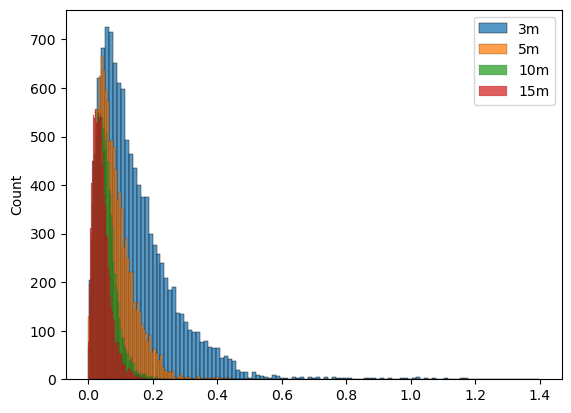

In [17]:
sns.histplot(sos_ds['wind_gradient_3m_c'], label='3m')
sns.histplot(sos_ds['wind_gradient_5m_c'], label='5m')
sns.histplot(sos_ds['wind_gradient_10m_c'], label='10m')
sns.histplot(sos_ds['wind_gradient_15m_c'], label='15m')
plt.legend()

# Calculate temp gradient for all data

In [18]:
sos_ds['temp_gradient_3m_c'] = (['time'], calculate_temperature_gradient_for_height(sos_ds, 3).values)
sos_ds['temp_gradient_5m_c'] = (['time'], calculate_temperature_gradient_for_height(sos_ds, 5).values)
sos_ds['temp_gradient_10m_c'] = (['time'], calculate_temperature_gradient_for_height(sos_ds, 10).values)
sos_ds['temp_gradient_15m_c'] = (['time'], calculate_temperature_gradient_for_height(sos_ds, 15).values)

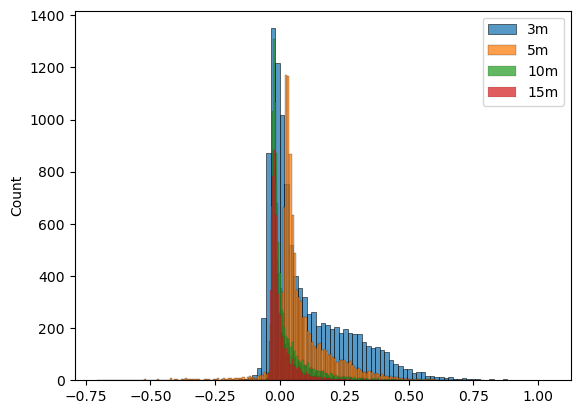

In [19]:
sns.histplot(sos_ds['temp_gradient_3m_c'], label='3m')
sns.histplot(sos_ds['temp_gradient_5m_c'], label='5m')
sns.histplot(sos_ds['temp_gradient_10m_c'], label='10m')
sns.histplot(sos_ds['temp_gradient_15m_c'], label='15m')
plt.legend()

# Calculate Gradient Richardson Number

In [33]:
import pint_xarray
import metpy
from metpy.units import units

In [42]:
def calculate_richardson_number(ds, height):
    multiplier = metpy.constants.g.magnitude / (sos_ds[f'Tvirtual_{height}m_c'] * units.celsius).pint.to(units.kelvin)
    Ri = multiplier * sos_ds[f'temp_gradient_{height}m_c'] / sos_ds[f'wind_gradient_{height}m_c']
    return Ri.pint.magnitude


In [45]:
sos_ds['Ri_3m_c'] = (['time'], calculate_richardson_number(sos_ds, 3))
sos_ds['Ri_5m_c'] = (['time'], calculate_richardson_number(sos_ds, 5))
sos_ds['Ri_10m_c'] = (['time'], calculate_richardson_number(sos_ds, 10))
sos_ds['Ri_15m_c'] = (['time'], calculate_richardson_number(sos_ds, 15))

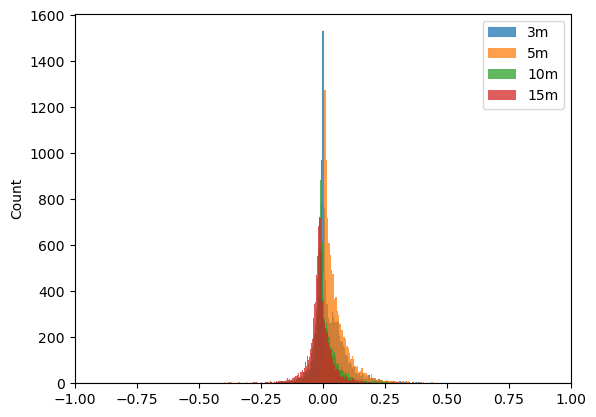

In [48]:
sns.histplot(sos_ds['Ri_3m_c'], label='3m')
sns.histplot(sos_ds['Ri_5m_c'], label='5m')
sns.histplot(sos_ds['Ri_10m_c'], label='10m')
sns.histplot(sos_ds['Ri_15m_c'], label='15m')
plt.xlim(-1,1)
plt.legend()

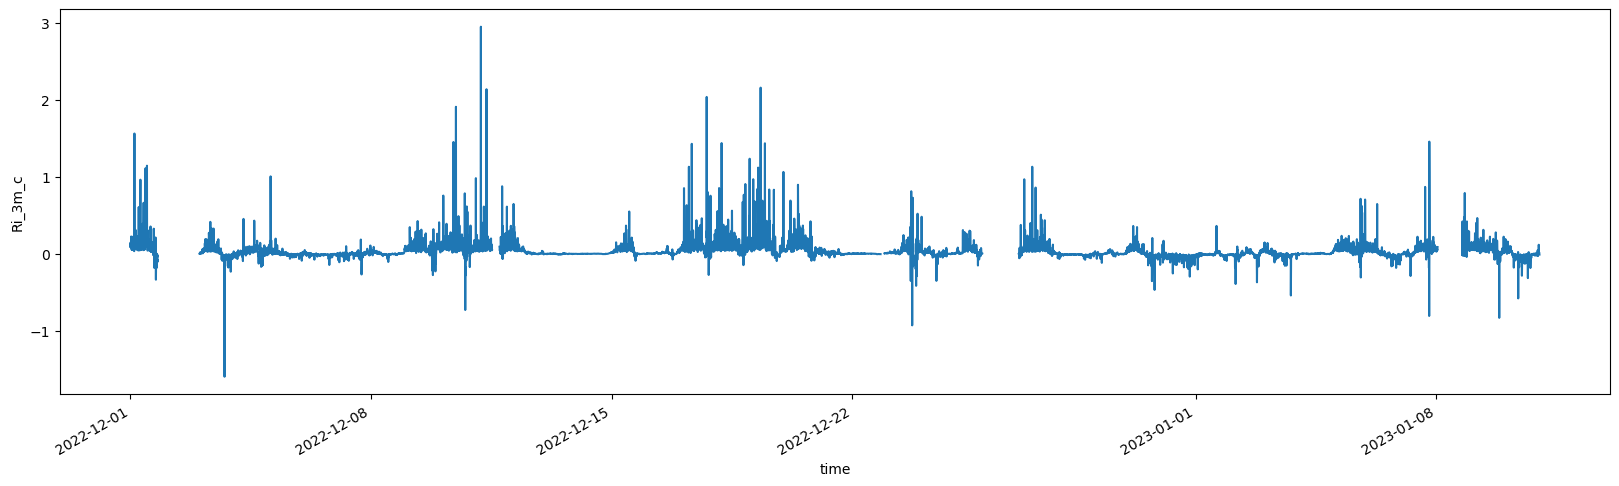

In [55]:
sos_ds['Ri_3m_c'].plot(figsize=(20,5))


# Show example of fitted log-linear curves

In [99]:
i = 228
heights = [2,3,5,10,15,20]
u_values = [
    sos_ds.sel(time = sos_ds.time.values[i])['u_2m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_3m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_5m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_10m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_15m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_20m_c']
]
v_values = [
    sos_ds.sel(time = sos_ds.time.values[i])['v_2m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_3m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_5m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_10m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_15m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_20m_c']
]
u_params = fit_log_linear(u_values, heights)
v_params = fit_log_linear(v_values, heights)
u_fitted_values = [log_linear_fn(h, u_params[0], u_params[1]) for h in heights]
v_fitted_values = [log_linear_fn(h, v_params[0], v_params[1]) for h in heights]

spd_values = [
    sos_ds.sel(time = sos_ds.time.values[i])['spd_2m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_3m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_5m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_10m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_15m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_20m_c']
]

dir_values = [
    sos_ds.sel(time = sos_ds.time.values[i])['dir_2m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_3m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_5m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_10m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_15m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_20m_c']
]

In [114]:
from collections.abc import Iterable

def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

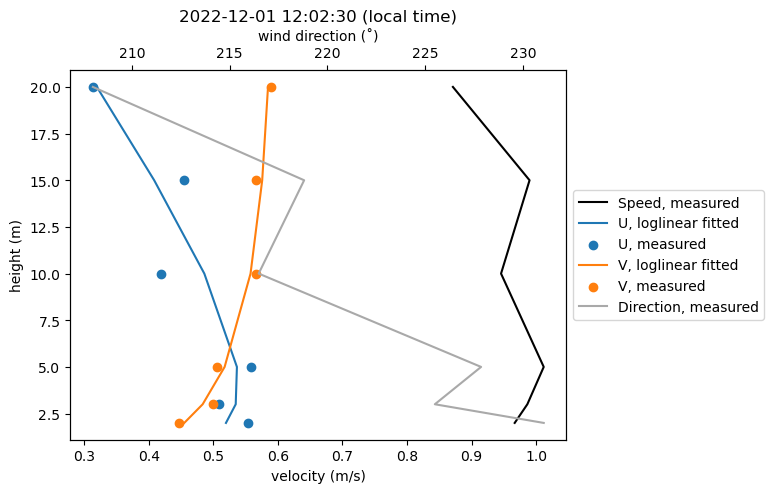

In [117]:
import datetime as dt
l1 = plt.plot(spd_values, heights, color='black', label='Speed, measured')

l2 = plt.plot(u_fitted_values, heights, color='tab:blue', label='U, loglinear fitted')
l3 = plt.scatter(u_values, heights, color='tab:blue', label='U, measured')

l4 = plt.plot(v_fitted_values, heights, color='tab:orange', label='V, loglinear fitted')
l5 = plt.scatter(v_values, heights, color='tab:orange', label='V, measured')

plt.xlabel("velocity (m/s)")
plt.ylabel("height (m)")

ax_twin = plt.gca().twiny()
l6 = ax_twin.plot(dir_values, heights, color='darkgrey', label='Direction, measured')
ax_twin.set_xlabel("wind direction (˚)")
plt.title(str(pd.to_datetime(sos_ds.time.values[i]) - dt.timedelta(hours=7)) + ' (local time)')

lns = list(flatten([l1,l2,l3,l4,l5,l6]))
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='center left', bbox_to_anchor=(1, 0.5))